In [29]:
%pip install pyexpat
%pip install scikit-learn
%pip install tqdm
%pip install pandas
%pip install spacy
%pip install matplotlib
%pip install seaborn
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyexpat (from versions: none)
ERROR: No matching distribution found for pyexpat


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
     ------- ----------------------------- 30.7/160.4 kB 660.6 kB/s eta 0:00:01
     ------------------------------------ - 153.6/160.4 kB 2.3 MB/s eta 0:00:01
     -------------------------------------- 160.4/160.4 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   - -------------------------------------- 0.2/7.6 MB 7.4 MB/s eta 0:00:02
   --- ------------------------------------ 0.6/7.6 MB 6.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.1/7.6 MB 7.5 MB/s eta 0:00:01
   ------- -------------------------------- 1.4/7.6 MB 7.6 MB/s eta 0:00:01
   --------- ------------------------------ 1.9/7.

ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'c:\\Python312\\share'
Consider using the `--user` option or check the permissions.



  Using cached matplotlib-3.8.2-cp312-cp312-win_amd64.whl.metadata (5.9 kB)
  Using cached contourpy-1.2.0-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.6 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.6 kB 435.7 kB/s eta 0:00:01
   ----------------------- ---------------- 174.1/294.6 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 2.0 MB/s eta 0:00:00
Using cached matplotlib-3.8.2-cp312-cp312-win_amd64.whl (7.6 MB)
Using cached contourpy-1.2.0-cp312-cp312-win_amd64.whl (187 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     -----

In [ ]:
from pyexpat import model
from sklearn.neighbors import KNeighborsClassifier

from tqdm import tqdm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import json


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [ ]:
def preTraitement():
    data_list = []

    with open('goodreads_reviews_spoiler.json', 'r') as fichier_json:
        lines = fichier_json.readlines()  
        for ligne in tqdm(lines, desc='Chargement des données'):
            try:
                objet_json = json.loads(ligne)
                data_list.append(objet_json)
            except json.JSONDecodeError:
                pass

    df = pd.json_normalize(data_list)

    df = df[df['has_spoiler'] == True]

    data_json = df.to_dict(orient='records')

    with open('onlyspoilers.json', 'w') as fichier_resultat:
        json.dump(data_json, fichier_resultat, indent=4)

In [ ]:
def spoilersFilter():
    print(bcolors.OKBLUE + "Chargment des données..." + bcolors.ENDC)
    df = pd.read_json('onlyspoilers.json')
    print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

    print(bcolors.OKBLUE + "Filtrage..." + bcolors.ENDC)
    df = df.drop_duplicates(subset=['user_id', 'book_id'])
    df['full_text'] = df['review_sentences'].apply(lambda sentences: ' '.join([sentence[1] for sentence in sentences]))
    df['label'] = df['rating'].apply(lambda x: 1 if x >= 3 else 0)  # 1 pour favorable, 0 pour défavorable
    df = df[['rating', 'label','full_text']]
    df = df.dropna(subset=['rating', 'label', 'full_text'])
    print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

    print(bcolors.OKBLUE + "Ecriture dans data.json..." + bcolors.ENDC)
    data_json = df.to_dict(orient='records')
    with open('data.json', 'w') as fichier_resultat:
        json.dump(data_json, fichier_resultat, indent=4)
    print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

In [ ]:
preTraitement()
spoilersFilter()

Chargement des données: 100%|██████████| 1378033/1378033 [01:14<00:00, 18601.20it/s]


Chargment des données...
OK
Filtrage...
OK
Ecriture dans data.json...
OK


In [ ]:
print(bcolors.OKBLUE + "Lecture..." + bcolors.ENDC)
df = pd.read_json('data.json')
# df = df.head(20000)
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

# Prétraitement avec spaCy
print(bcolors.OKBLUE + "Prétraitement avec spaCy..." + bcolors.ENDC)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
print(bcolors.OKCYAN + "nlp loading..." + bcolors.ENDC)
def preprocess(texts):
    return [' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct]) 
            for doc in tqdm(nlp.pipe(texts, batch_size=50), total=len(texts))]

df['processed_text'] = preprocess(df['full_text'].tolist())
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

# Vectorisation
print(bcolors.OKBLUE + "Vectorisation..." + bcolors.ENDC)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['processed_text'])
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

Lecture...
OK
Prétraitement avec spaCy...
nlp loading...


100%|██████████| 89627/89627 [31:24<00:00, 47.55it/s]  


OK
Vectorisation...
OK


In [38]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN
print(bcolors.OKBLUE + "KNN..." + bcolors.ENDC)
knn_model = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7, 9]}
knn_clf = GridSearchCV(knn_model, knn_params)
knn_clf.fit(X_train, y_train)
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)


# Évaluation de KNN
print(bcolors.OKBLUE + "Évaluation de KNN..." + bcolors.ENDC)
y_pred_knn = knn_clf.predict(X_test)
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn, zero_division=1))
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

KNN...
OK
Évaluation de KNN...
KNN Classification Report
              precision    recall  f1-score   support

           0       0.28      0.02      0.04      2993
           1       0.83      0.99      0.91     14933

    accuracy                           0.83     17926
   macro avg       0.56      0.51      0.47     17926
weighted avg       0.74      0.83      0.76     17926

OK


Réduction de dimension avec TruncatedSVD...
Réduction de dimension avec t-SNE...
Visualisation...


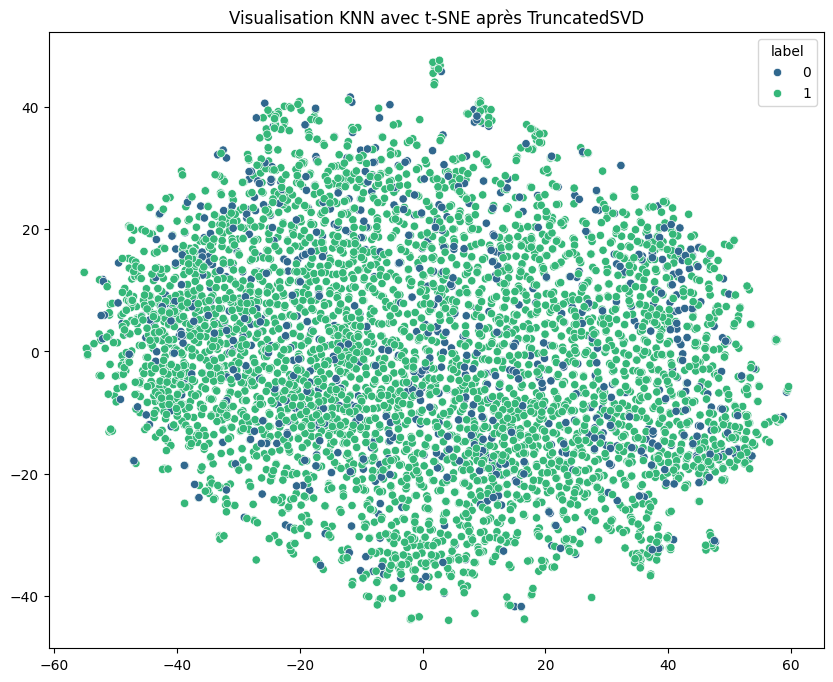

In [39]:
# Échantillonnage
sample_size = 5000
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sampled = X_train[indices]
y_sampled = y_train.iloc[indices]

# Réduction de dimension avec TruncatedSVD
print("Réduction de dimension avec TruncatedSVD...")
svd = TruncatedSVD(n_components=50)
X_reduced_svd = svd.fit_transform(X_sampled)

# Réduction de dimension avec t-SNE
print("Réduction de dimension avec t-SNE...")
X_reduced_tsne = TSNE(n_components=2).fit_transform(X_reduced_svd)

# Visualisation
print("Visualisation...")
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_reduced_tsne[:, 0], y=X_reduced_tsne[:, 1], hue=y_sampled, palette='viridis')
plt.title("Visualisation KNN avec t-SNE après TruncatedSVD")
plt.show()


In [20]:
y = df['rating']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN
print(bcolors.OKBLUE + "KNN..." + bcolors.ENDC)
knn_model = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7, 9]}
knn_clf = GridSearchCV(knn_model, knn_params)
knn_clf.fit(X_train, y_train)
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)


# Évaluation de KNN
print(bcolors.OKBLUE + "Évaluation de KNN..." + bcolors.ENDC)
y_pred_knn = knn_clf.predict(X_test)
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn, zero_division=1))
print(bcolors.OKGREEN + "OK" + bcolors.ENDC)

KNN...
OK
Évaluation de KNN...
KNN Classification Report
              precision    recall  f1-score   support

           0       0.05      0.05      0.05       285
           1       0.05      0.02      0.03       675
           2       0.18      0.05      0.07      2033
           3       0.31      0.31      0.31      4531
           4       0.37      0.49      0.42      6147
           5       0.38      0.37      0.38      4255

    accuracy                           0.34     17926
   macro avg       0.23      0.21      0.21     17926
weighted avg       0.32      0.34      0.32     17926

OK


In [28]:
print(knn_clf.predict(vectorizer.transform(preprocess(["Well, where do I even start. Let's start off with the fact that I came into this book completely blind; I had no idea what this book was about. In fact, for some reason I had this notion that this book was going to be about mental illness. So, seeing as how I came into this book knowing nothing about it, imagine my surprise when I started reading it and I read nonsense. Turns out, this book is filled with a made up language based off of Russian slang. I saw some reviews praising the author for making the slang accessible and easy to follow and learn. All I have to say about that is 'speak for yourself.' I had no idea how to read this and I was barely getting along until I finally looked up a glossary and memorized a few of the more commonly used words. Besides the difficulty I faced in reading this book, I guess I just don't \"get it.\" The ultraviolence turned me off, which I guess was the point, however, I know a lot of people felt sorry for Alex and what he went through, well, not me. I'm not saying he deserved  everything  he got, but he deserved a lot of it. He was a borderline psychopath who got off on violence and being an overall shitty human being. I have no sympathy for what he went through. I think what made me lose any and all compassion I might have had for him is when he  got two 10 year old girls drunk, brought them home, then raped them. I don't get the theme warning about government control and whatever -- maybe they crossed the line but it's hard to care when the only example of that we're showed is what happened to Alex. Overall, I thought this book sucked. I almost gave up after page 20 but I powered through thinking about all the good reviews on goodreads. In hindsight, I should have just read wikipedia. This book was a real pain in the ass to read. If anyone wants to try and explain to me whatever I'm not seeing, that'd be nice. Can't say I'd agree with you, though."]))))

100%|██████████| 1/1 [00:00<00:00, 38.44it/s]


[3]


Réduction de dimension avec TruncatedSVD...
Réduction de dimension avec t-SNE...
Visualisation...


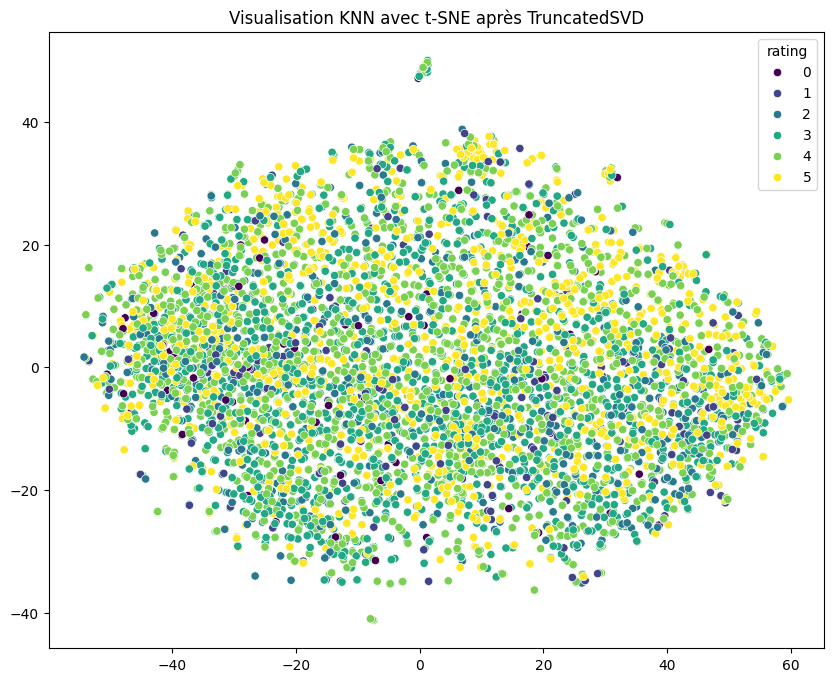

In [34]:
# Échantillonnage
sample_size = 5000
indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_sampled = X_train[indices]
y_sampled = y_train.iloc[indices]

# Réduction de dimension avec TruncatedSVD
print("Réduction de dimension avec TruncatedSVD...")
svd = TruncatedSVD(n_components=50)
X_reduced_svd = svd.fit_transform(X_sampled)

# Réduction de dimension avec t-SNE
print("Réduction de dimension avec t-SNE...")
X_reduced_tsne = TSNE(n_components=2).fit_transform(X_reduced_svd)

# Visualisation
print("Visualisation...")
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_reduced_tsne[:, 0], y=X_reduced_tsne[:, 1], hue=y_sampled, palette='viridis')
plt.title("Visualisation KNN avec t-SNE après TruncatedSVD")
plt.show()
